In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
n = 200

x = np.zeros((n, 1))
V = np.zeros((n, 1))
z = np.zeros((n, 1))

x[0] = 5
V[0] = 1
T = 1
gate = 0.2

sigma_a_2 = 0.2 ** 2
sigma_eta_2 = 20 **2
a = np.random.normal(0, np.sqrt(sigma_a_2), n-1)
et = np.random.normal(0, np.sqrt(sigma_eta_2), n)

for i in range(n):
    x[i] = x[i-1] + V[i-1] * T + ((a[i-1]*T)**2)/2
    V[i] = V[i-1] + a[i-1]*T
    z[i] = x[i] + et[i]

In [3]:
def missdata(z, gate):
    data = np.zeros((n, 1))
    for i in range(n):
        baseline = random.random()
        if baseline >= gate:
            data[i] = z[i]
        else:
            data[i]= None
    return(data)

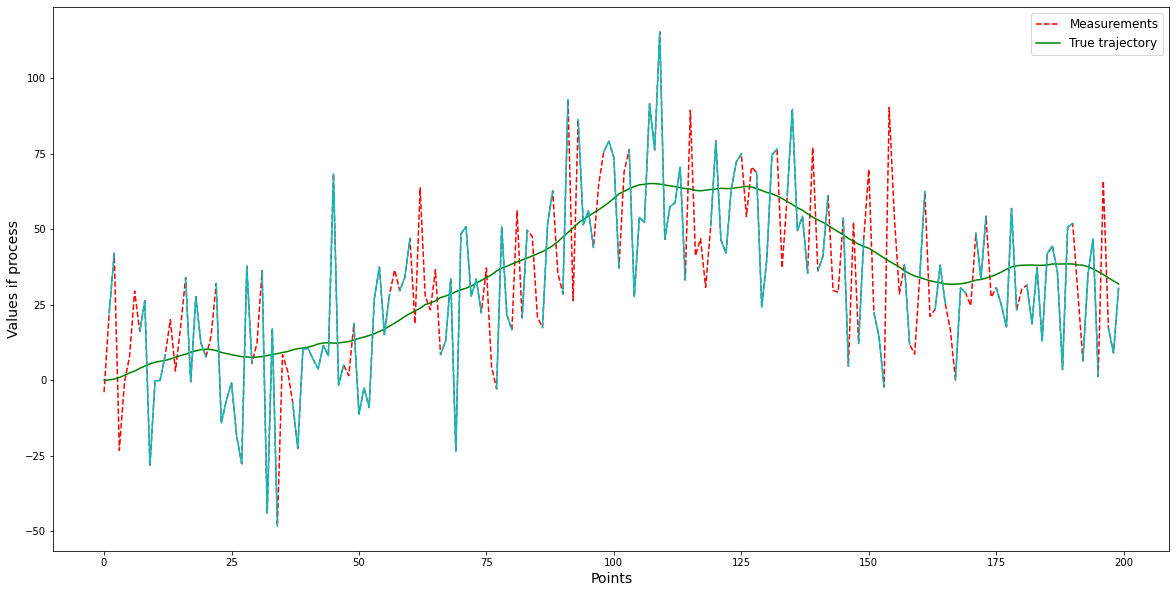

In [4]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.2), label = "", color = "c")
plt.legend(fontsize = 12)

In [5]:
phi = np.array([[1, T], [0, 1]])
G = np.array([[(T**2)/2],[T]])
H = np.array([1, 0])
Z = np.zeros((2, n))
X = np.array([[5], [1]])

X_ = X

for i in range(1, len(a)+1):
    X = np.hstack((X, phi.dot(X_) + G * a[i - 1]))
    X_ = phi.dot(X_) + G * a[i-1]

In [6]:
def kalman(z):    
    Q = G * G.T * sigma_a_2

    R=sigma_eta_2

    # Initialization of matrixes
    P_pred = np.zeros((2, 2, n))
    X_pred = np.zeros((2, n))
    #X_pred[:, 0] = [2, 0]
    P_filt = np.zeros((2, 2, n))
    X_filt = np.zeros((2, n))
    K = np.zeros((2, n))
    HT = H.T

     #Initial P for filtering
    P_filt[:, :, 0] = [[10000, 0],[0, 10000]]
    #Initial X_filt for filtering
    X_filt[:, 0] = [2, 0]

     # Kalman filtering
    for i in range(1, n):
        X_pred[:, i] = phi.dot(X_filt[:, i - 1].reshape(2, 1)).reshape(2)
        P_pred[:, :, i] = (phi.dot(P_filt[:, :, i - 1])).dot(phi.T) + Q

        K[:, i] = ((P_pred[:, :, i].dot(H.T)) / ((H.dot(P_pred[:, :, i])).dot(H.T) + R)).reshape(2)
    #    print(X_pred[:,i])
        if np.isnan(missdata(z, 0.2)[i]):
            X_filt[:, i] = X_pred[:, i]
            P_filt[:, :, i] = P_pred[:, :, i]  
        else:       
            X_filt[:, i] = X_pred[:, i] + K[:, i] * (z[i] - H.dot(X_pred[:, i]))
            P_filt[:, :, i] = (np.eye(2) - K[:, i].reshape(2, 1) * H).dot(P_pred[:, :, i])

    K = np.delete(K, 0, axis = 1)
    
    return(X, X_pred, X_filt, K, np.sqrt(P_pred[0, 0,:]), np.sqrt(P_filt[0, 0,:]))

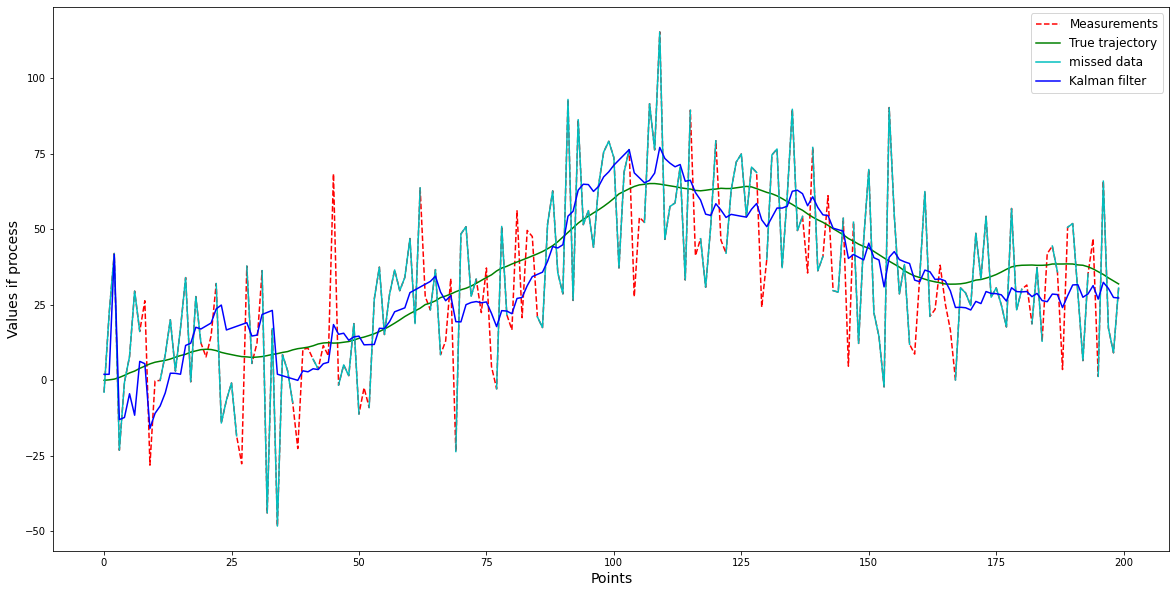

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.2), label = "missed data", color = "c")
ax.plot(kalman(missdata(z, 0.2))[2][0,:], label = "Kalman filter", color = 'b')
plt.legend(fontsize = 12)

In [8]:
M = 500
N = 200

Error = np.zeros((2, n, M))
Error_1step = np.zeros((2, N, M))
Error_7steps = np.zeros((2, N, M))

X_1 = np.zeros((2, N))
X_7 = np.zeros((2, N + 7))
phi10 = np.array([[1, T], [0, 1]])

X = kalman(missdata(z, 0.2))[0]
X_ = kalman(missdata(z, 0.2))[2]

for k in range(M):
    for i in range(N):
        X_1[:, i] = phi.dot(X_[:, i].reshape(2, 1)).reshape(2)
        X_7[:, i] = phi10.dot(phi10).dot(phi10).dot(phi10).dot(phi10).dot(phi10).dot(X_[:, i].reshape(2, 1)).reshape(2)
        
    Error_1step[:, :, k] = (X - X_1[:, :N]) ** 2
    Error_7steps[:, :, k] = (X - X_7[:, :N]) ** 2
    
Final_error_1step = np.sqrt(np.sum(Error_1step, axis = 2) / (M - 1))
Final_error_7steps = np.sqrt(np.sum(Error_7steps, axis = 2) / (M - 1))

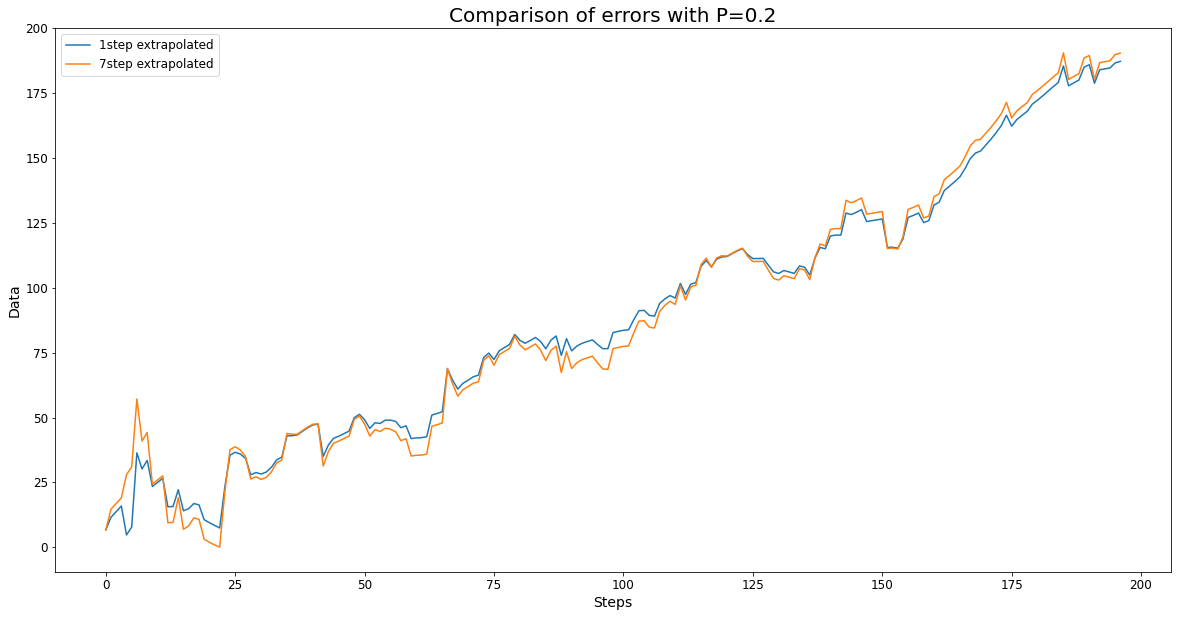

In [9]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_title("Comparison of errors with P=0.2", fontsize = 20)
ax.set_ylabel('Data', fontsize = 14)
ax.set_xlabel('Steps', fontsize = 14)
ax.plot(Final_error_1step[0, 3:], label = "1step extrapolated")
ax.plot(Final_error_7steps[0, 3:], label = "7step extrapolated")
ax.tick_params(labelsize = 12)
plt.legend(fontsize = 12)

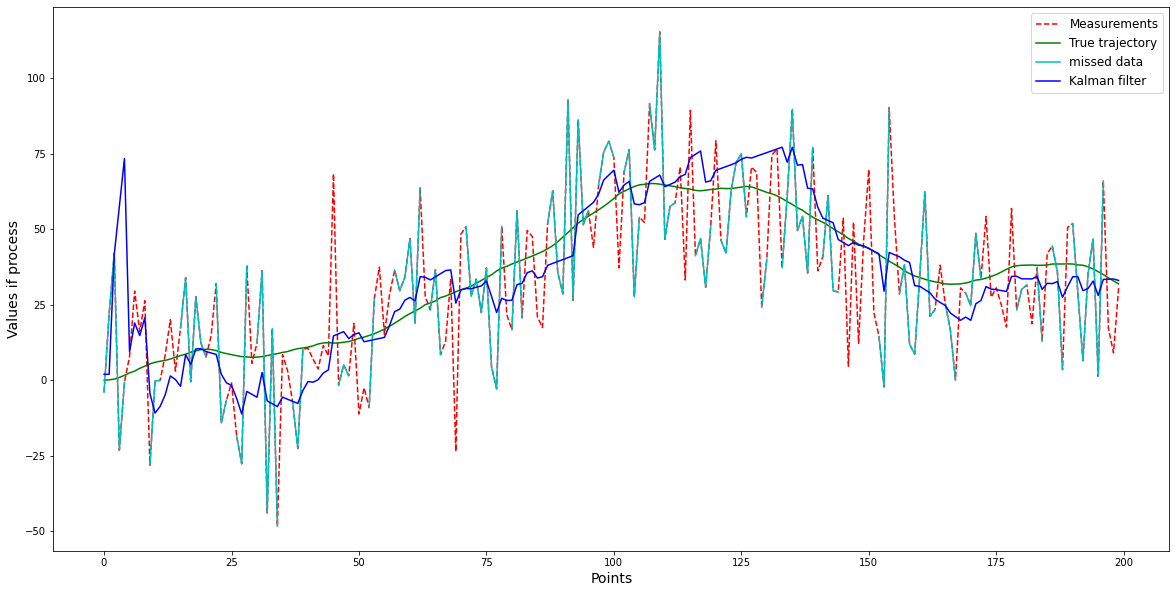

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.3), label = "missed data", color = "c")
ax.plot(kalman(missdata(z, 0.3))[2][0,:], label = "Kalman filter", color = 'b')
plt.legend(fontsize = 12)

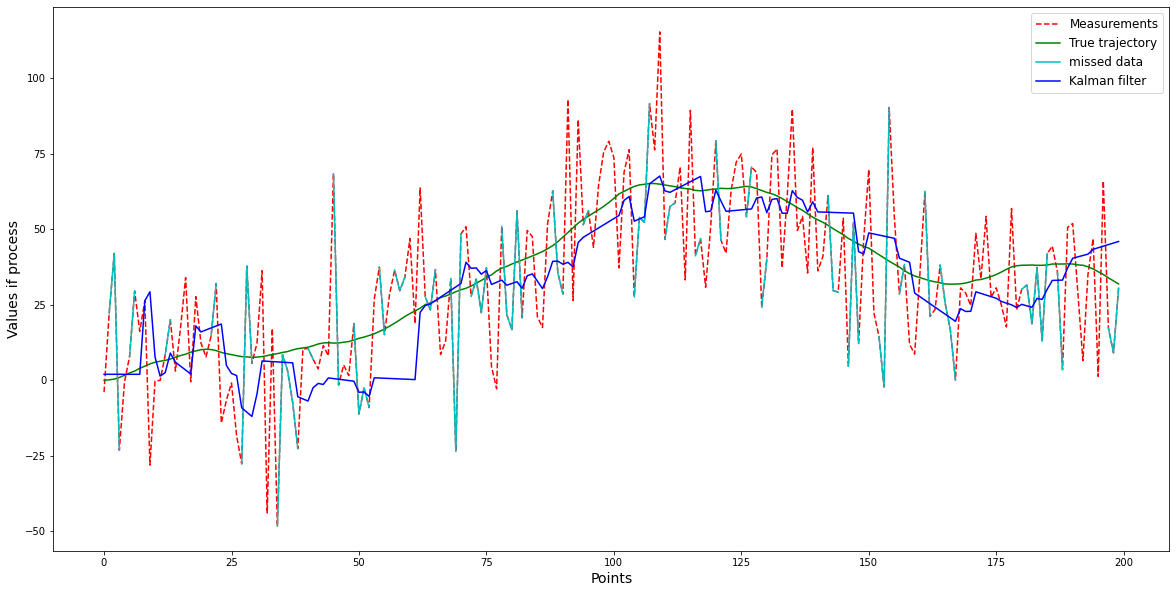

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.5), label = "missed data", color = "c")
ax.plot(kalman(missdata(z, 0.5))[2][0,:], label = "Kalman filter", color = 'b')
plt.legend(fontsize = 12)

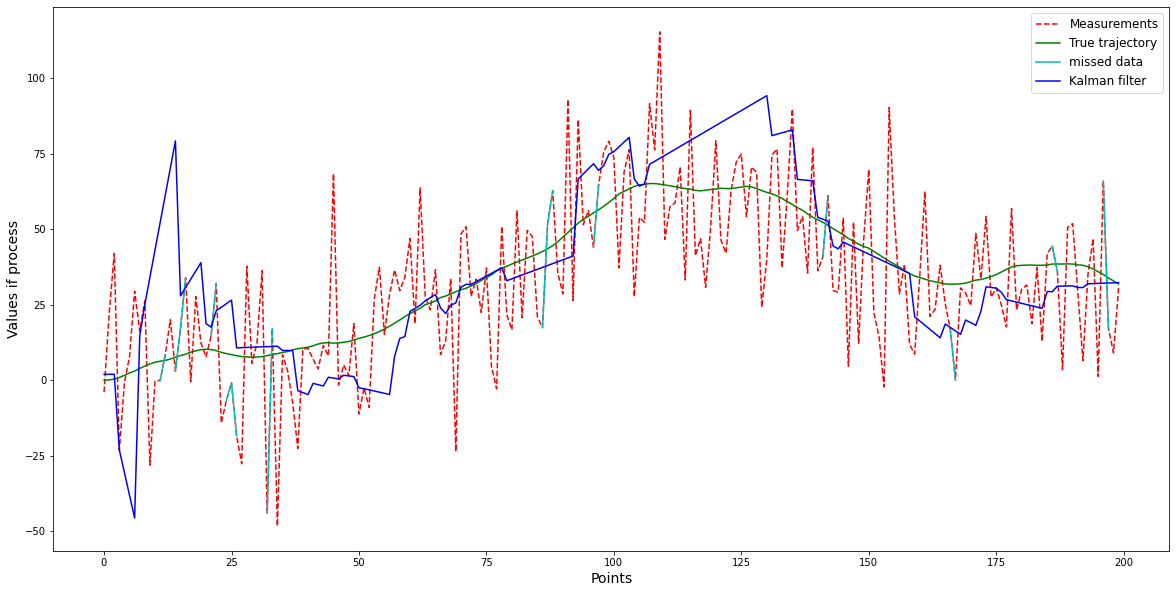

In [12]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.7), label = "missed data", color = "c")
ax.plot(kalman(missdata(z, 0.7))[2][0,:], label = "Kalman filter", color = 'b')
plt.legend(fontsize = 12)

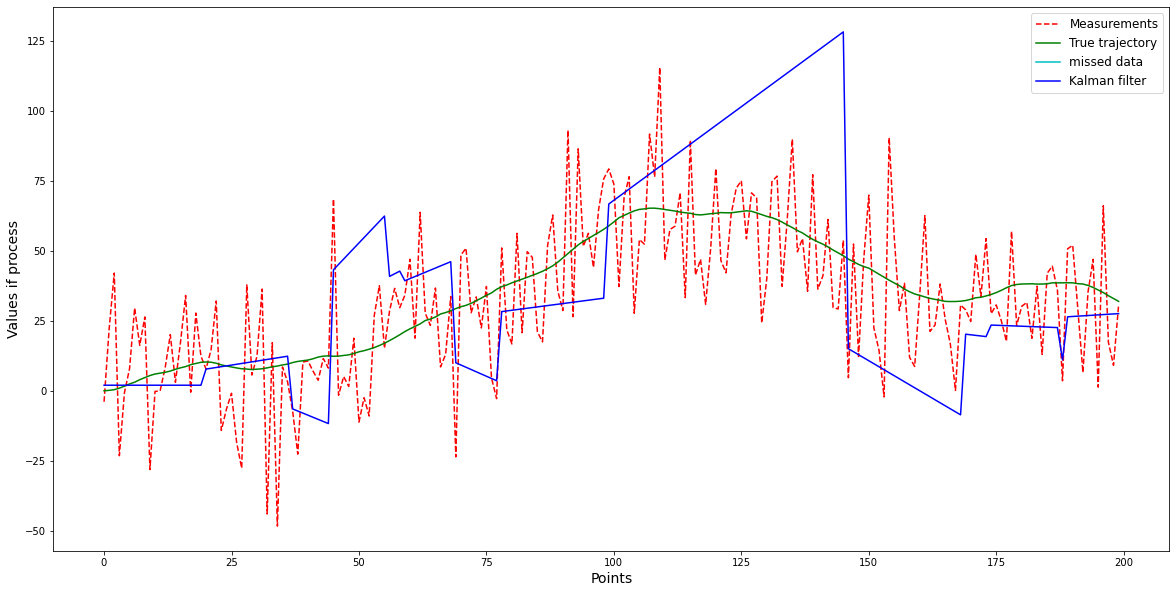

In [13]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel('Values if process', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.plot(z, '--', label = "Measurements", color = 'r')
ax.plot(x, label = "True trajectory", color = "g")
ax.plot(missdata(z, 0.9), label = "missed data", color = "c")
ax.plot(kalman(missdata(z, 0.9))[2][0,:], label = "Kalman filter", color = 'b')
plt.legend(fontsize = 12)